# 주요 라이브러리 버전 확인

In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


# 필요한 라이브러리 Import

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

# 데이터 불러오기 및 확인

In [3]:
PATH = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/'
data_path = os.path.join(PATH, 'train/')

# 데이터 개수 확인
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


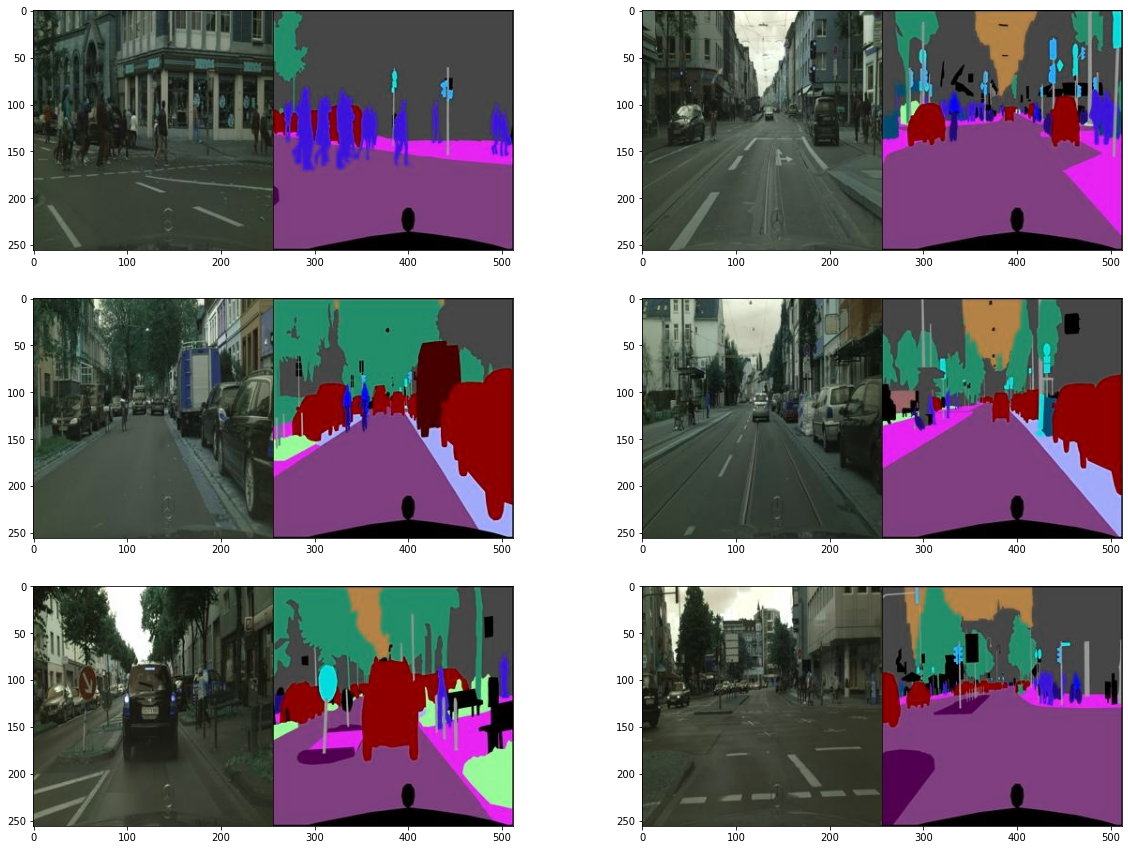

In [4]:
# 무작위 6개 이미지 시각화하여 확인
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [5]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [6]:
# 스케치 이미지와 실제 사진 이미지 분리
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

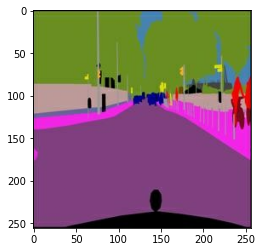

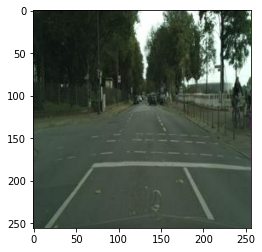

In [7]:
# 스케치 이미지와 실제 사진 이미지 확인
f = data_path + os.listdir(data_path)[np.random.randint(800)]  
inp, re = load(f)
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

# 데이터 Augmentation

* 무작위 지터링에서 이미지의 크기는 286 x 286로 조정되고 다시 256 x 256로 무작위로 잘립니다.
* 무작위 미러링에서는 이미지가 무작위로 좌우 반전됩니다.

In [8]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [10]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [11]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [13]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

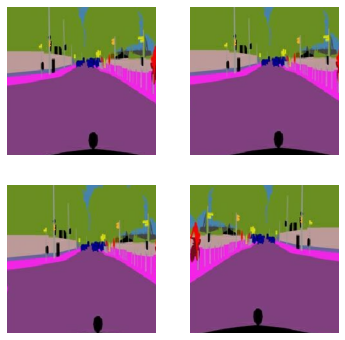

In [14]:
# 무작위 지터링과 미러링을 거친 이미지 확인
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

데이터 불러오기 및 전처리가 작동하는지 확인한 후, train 및 test set을 불러오기 및 전처리를 수행하는 함수를 정의합니다.

In [15]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [16]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

# 입력 파이프라인

In [17]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [18]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [19]:
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [20]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>

# 생성기 빌드하기

* 생성기 아키텍처는 수정된 U-Net입니다.
* 인코더의 각 블록은 (Conv -> Batchnorm -> Leaky ReLU)입니다.
* 디코더의 각 블록은 (Transposed Conv -> Batchnorm -> Dropout(처음 3개의 블록에 적용됨)-> ReLU)입니다.
* 인코더와 디코더 사이에는 (U-Net에서와 같이) 스킵(skip) 연결이 있습니다.

In [21]:
OUTPUT_CHANNELS = 3

In [22]:
# downsampler(encoder) 정의
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [23]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [24]:
# upsampler(decoder) 정의
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [26]:
# downsampler와 upsampler를 가지고 generator 정의
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
      downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
      downsample(128, 4),  # (batch_size, 64, 64, 128)
      downsample(256, 4),  # (batch_size, 32, 32, 256)
      downsample(512, 4),  # (batch_size, 16, 16, 512)
      downsample(512, 4),  # (batch_size, 8, 8, 512)
      downsample(512, 4),  # (batch_size, 4, 4, 512)
      downsample(512, 4),  # (batch_size, 2, 2, 512)
      downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
      upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
      upsample(512, 4),  # (batch_size, 16, 16, 1024)
      upsample(256, 4),  # (batch_size, 32, 32, 512)
      upsample(128, 4),  # (batch_size, 64, 64, 256)
      upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

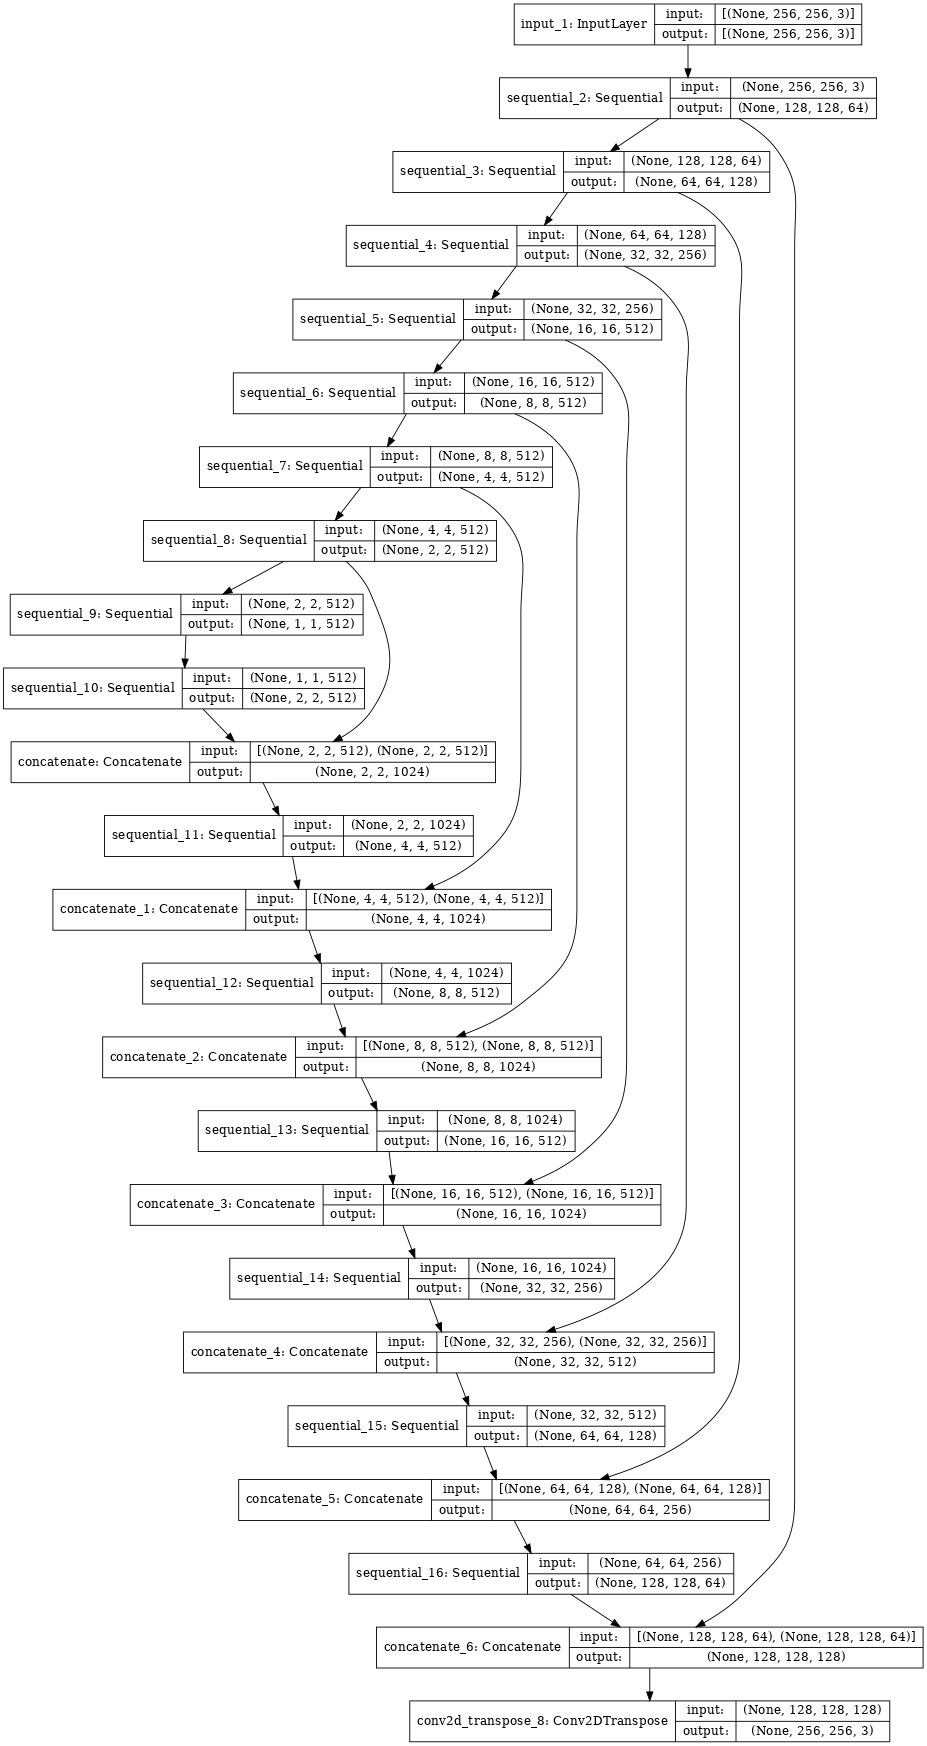

In [27]:
# generator model의 구조 시각화
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


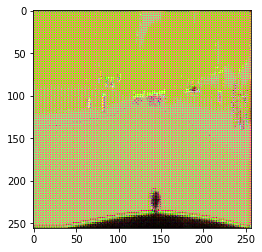

In [28]:
# generator 테스트
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### 생성기 손실(Generator loss) 정의

* 생성된 이미지 및 1의 배열의 시그모이드 교차 엔트로피 손실입니다.
* 논문에는 생성 이미지와 대상 이미지 사이의 MAE(평균 절대 오차)인 L1 손실도 포함됩니다.
* 이를 통해 생성된 이미지가 대상 이미지와 구조적으로 유사해질 수 있습니다.
* 총 생성기 손실을 계산하는 공식 = gan_loss + LAMBDA * l1_loss. 여기서 LAMBDA = 100. 이 값은 논문 작성자가 결정했습니다.

In [29]:
LAMBDA = 100

In [30]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

생성기의 훈련 절차는 다음과 같습니다.

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


# 판별자 빌드하기

* 판별자는 PatchGAN입니다.
* 판별자의 각 블록은 (Conv -> BatchNorm -> Leaky ReLU)입니다.
* 마지막 레이어 이후의 출력 형상은 (batch_size, 30, 30, 1)입니다.
* 출력의 각 30x30 패치는 입력 이미지의 70x70 부분을 분류합니다(이러한 아키텍처를 PatchGAN이라고 함).
* 판별자는 2개의 입력을 받습니다.
    * 진짜로 분류해야 하는 입력 이미지 및 대상 이미지
    * 가짜로 분류해야 하는 입력 이미지 및 생성된 이미지(생성기의 출력)
    * 코드에서 이 두 입력을 함께 연결합니다(tf.concat([inp, tar], axis=-1)).

In [32]:
# 판별자 정의
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

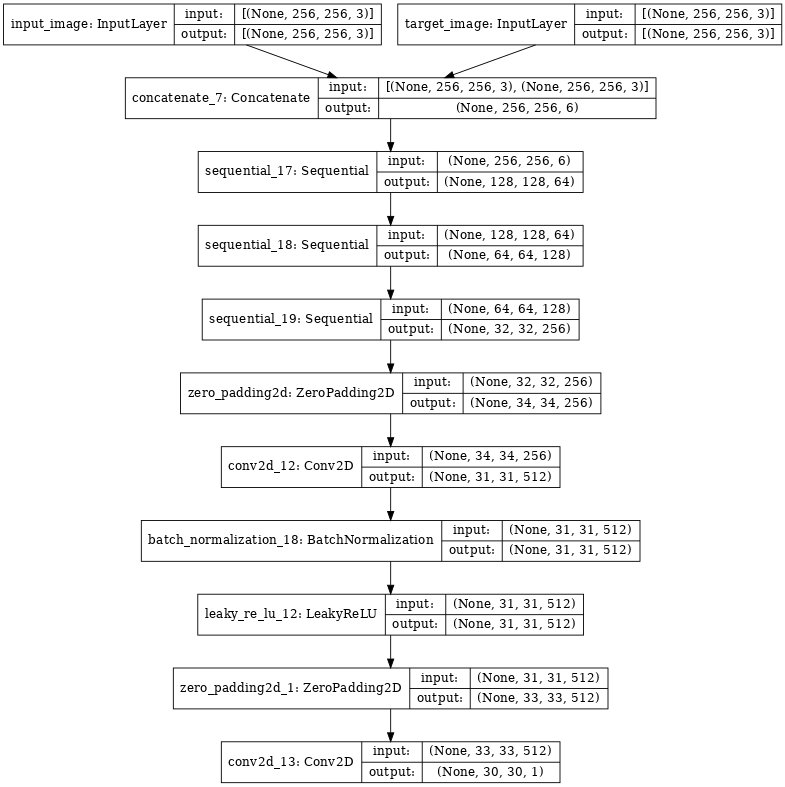

In [33]:
# discriminator model의 구조 시각화
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

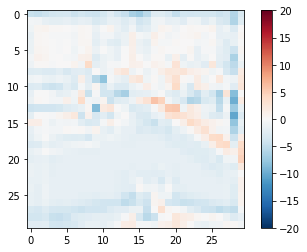

In [34]:
# discriminator 테스트
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### 판별자 손실

* 판별자 손실 함수는 진짜 이미지, 생성된 이미지의 두 입력을 받습니다.
* real_loss는 진짜 이미지 및 1의 배열(진짜 이미지이기 때문)의 시그모이드 교차 엔트로피 손실입니다.
* generated_loss는 생성된 이미지 및 0의 배열(가짜 이미지이기 때문)의 시그모이드 교차 엔트로피 손실입니다.
* 그리고 total_loss는 real_loss와 generated_loss의 합계입니다.

In [35]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

판별기의 훈련 절차는 다음과 같습니다.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


# Optimizers and와 checkpoint-saver 정의하기

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 이미지 생성하기

훈련 중에 일부 이미지를 시각화하는 함수를 작성합니다.

* test 데이터셋의 이미지를 생성기로 전달합니다.
* 그러면 생성기가 입력 이미지를 출력으로 변환합니다.
* 마지막 단계로 예측한 이미지(predicted image)를 플로팅합니다. 짜잔!

참고: 여기서 training=True는 test 데이터셋에서 모델을 실행하는 동안 batch 통계를 얻으려고 하므로 의도적인 것입니다.    
training = False를 사용하면 train 데이터셋에서 학습한 누적 통계(이것을 원하지는 않음)를 얻게 됩니다.

In [39]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

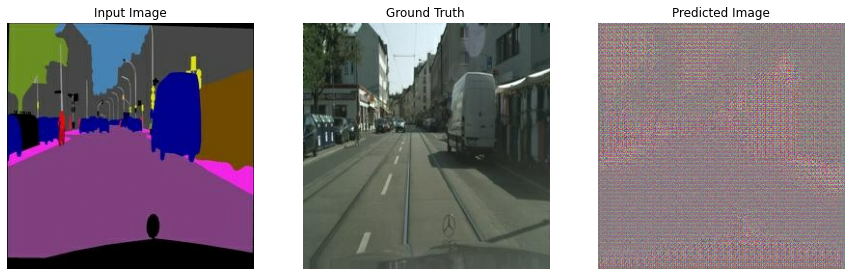

In [40]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

# 훈련하기

* 각 예에서 입력은 출력을 생성합니다.
* 판별자는 input_image 및 생성된 이미지를 첫 번째 입력으로 받습니다. 두 번째 입력은 input_image와 target_image입니다.
* 다음으로 생성기와 판별자 손실을 계산합니다.
* 그런 다음 생성기와 판별자 변수(입력) 모두에 대해 손실의 그래디언트를 계산하고 이를 옵티마이저에 적용합니다.
* 그런 다음 손실을 TensorBoard에 기록합니다.

In [41]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [42]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

실제 훈련 루프:

* epoch 수에 대해 반복합니다.
* 각 epoch에서 표시 내용을 지우고 generate_images를 실행하여 진행 상황을 표시합니다.
* 각 epoch마다 훈련 데이터세트에 대해 반복하여 각 예에 대해 '.'를 인쇄합니다.
* 20 epoch마다 체크포인트를 저장합니다.

In [43]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

      # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

      # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

이 훈련 루프는 TensorBoard에서 쉽게 볼 수 있는 로그를 저장하여 훈련 진행 상황을 모니터링합니다.    
로컬에서 작업하면 별도의 TensorBoard 프로세스가 시작됩니다. 노트북에서 TensorBoard로 모니터링하려는 경우 훈련을 시작하기 전에 뷰어를 시작하는 것이 편합니다.

뷰어를 시작하려면 다음을 코드 셀에 붙여넣습니다.   
```
%load_ext tensorboard   
%tensorboard --logdir {log_dir}
```

이제 훈련 루프를 실행합니다.

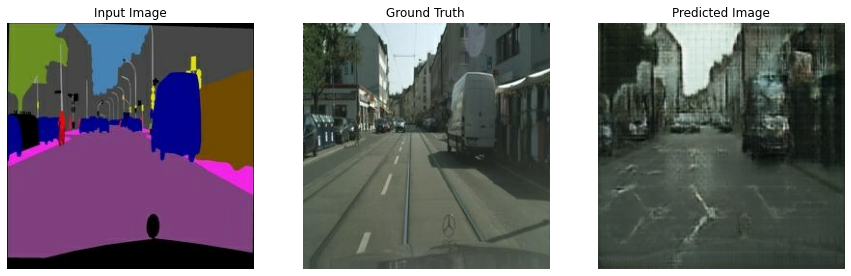

Epoch:  9
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

In [46]:
fit(train_dataset, 10, test_dataset)

TensorBoard 결과를 공개적으로 공유하려면 다음을 코드 셀에 복사하여 TensorBoard.dev에 로그를 업로드할 수 있습니다.

참고: 이를 위해 구글 계정이 필요합니다.

```
!tensorboard dev upload --logdir {log_dir}
```

주의: 이 명령은 종료되지 않습니다. 장기 실행되는 실험 결과를 지속적으로 업로드하도록 설계되었습니다. 데이터가 업로드되면 노트북 도구에서 "실행 중단" 옵션을 사용하여 실행을 중단시켜야 합니다.

TensorBoard.dev에서 이 노트북의 이전 실행 결과를 볼 수 있습니다.

TensorBoard.dev는 ML 실험을 호스팅 및 추적하고 모든 사람과 공유하기 위한 관리 환경입니다.

<iframe>을 사용하여 인라인으로 포함할 수도 있습니다.

In [47]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

GAN의 로그 해석은 단순한 분류 또는 회귀 모델보다 까다롭습니다.   
   
살펴 보아야 할 내용:

* 어떤 모델에도 "won"이 없는 것을 확인합니다. gen_gan_loss 또는 disc_loss가 매우 낮아지면 이 모델이 다른 모델을 지배하고 있고 결합된 모델을 성공적으로 훈련하지 못하고 있음을 나타냅니다.
* log(2) = 0.69 값은 판별자가 두 옵션에 대해 평균적으로 동일하게 확신하지 못함을 의미하는 2의 perplexity를 나타내기 때문에 이러한 손실에 대한 좋은 기준점입니다.
* disc_loss의 경우 0.69 미만의 값은 진짜 + 생성된 이미지의 결합된 세트에서 판별자가 무작위보다 성능이 좋음을 나타냅니다.
* gen_gan_loss의 경우 0.69 미만의 값은 생성기 i가 무작위보다 판별자를 더 잘 속인다는 것을 의미합니다.
* 훈련이 진행됨에 따라 gen_l1_loss가 줄어듭니다.

# 최신 checkpoint를 복원하고 테스트

In [48]:
!ls {checkpoint_dir}

checkpoint  ckpt-1.data-00000-of-00001	ckpt-1.index


In [49]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# 테스트 데이터셋을 사용하여 생성하기

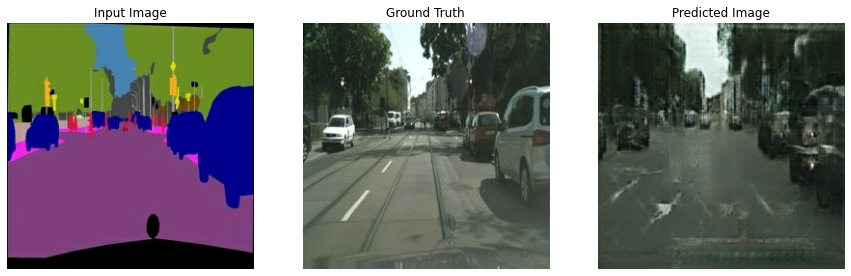

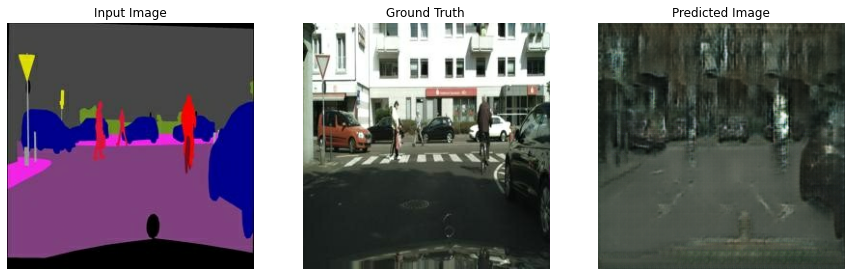

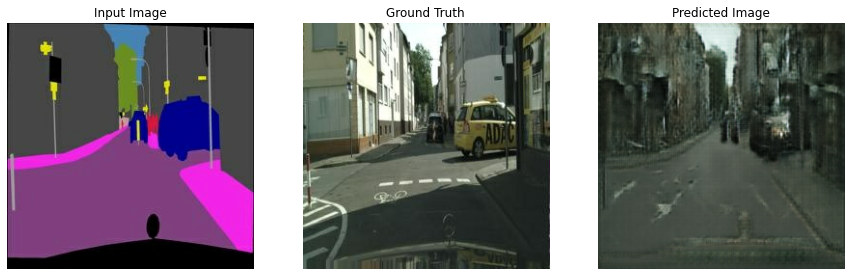

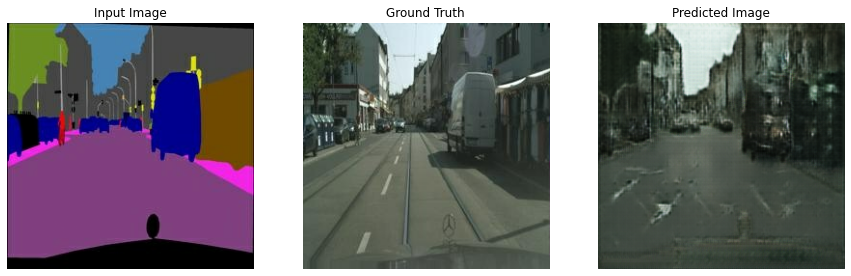

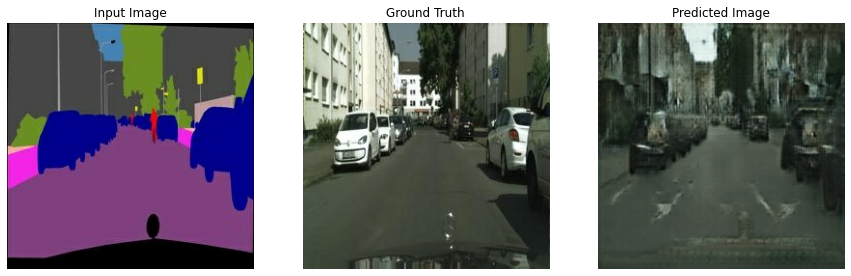

In [50]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

# 회고

이번 Exploration은 Tensorflow pix2pix tutorial을 기반으로, 어렵지 않게 완료했다. 덕분에 처음으로 당일 완성한 Exploration 프로젝트이기도 하다(비록 회고 쓰는 걸 미루다 제출 마감일에 제출 하지만). 원문에서는 학습을 50epoch인가 수행했지만, 난 모든 수단과 방법을 동원해 가능한 최소의 일만 하고자 하기에 프로젝트에서 요구하는 최소단위 10epoch만 돌렸는데도 꽤 준수한 결과물을 얻었다. 테스트 데이터셋으로 만든 가짜 이미지를 자세히 뜯어보면 뭔가 이상하지만 슬쩍 보면 얼추 좌우로 건물이 있고 자동차가 다니는 도로의 풍경처럼 보인다. 학습한 과정이 외부(Tensorboard)로 저장되어 그런가 코드를 Run했을 당시에는 파일 내에서 "학습 과정에서 loss가 줄어드는 그래프"가 이미지로 보였는데, 회고를 적으려 저장했던 파일을 다시 켜니 보이지 않아 루브릭 2번은 날아간걸까 싶다. 그런데 언제 별 개수에 연연했던가? 어떻게든 제출한다는 것 만으로 대견할 일이므로 그냥 제출하련다.

유사 스티커앱 만들기, segmentation을 이용한 배경과 피사체 이미지 합성, GAN 등 이미지 관련 Fundamental이나 Exploration은 마주치면 반갑고, 내용도 재미있고, 프로젝트를 수행하는 과정도 다른 주제에 비해 비교적 수월한 편인데, 야간 게더에서 다른 강냉이분들과 이야기 해보니 이에 도메인 지식이 지대한 영향을 끼쳤다는 걸 깨달았다. segmentation활용 Exploration을 수행하며 가우시안 블러의 동작 원리를 알았을때도 느꼈지만, 역시 모든 분야는 예상치 못한 곳에서 이어져 있구나~ 더하여 아이펠 과정에서 습득한 "도메인 지식"이라는 용어가 아주 유용해서 어디든 갖다 쓰게 되지 않냐며 지호님 빈님과 스몰토크도 나누었다. AI가 궁금해서 냅다 지원한 아이펠 과정에서 생각보다 AI말고도 많은 것을 알아간다.